# Import Libraries

In [2]:
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from itertools import groupby
import math
import neurokit2 as nk
from datetime import datetime
import json
import re
from scipy.stats import linregress
import os 
from itertools import product
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, lfilter
import time


# https://neuropsychology.github.io/NeuroKit/functions/eog.html

In [3]:
def column_str_to_float(data, column_names_arr): 
    # Remove non-numeric characters using regex
    for col_name in column_names_arr: 
        data[col_name] = pd.to_numeric(data[col_name], errors='coerce')
        
def parse_datetime(cell_value):
    try: 
        cleaned_value = cell_value.strip('"')
    except: 
        pass
    return datetime.strptime(cleaned_value, '%Y-%m-%d %H:%M:%S.%f')

def extract_name(json_str):
    try:
        label_dict = json.loads(json_str)
        if 'label' in label_dict:
            if isinstance(label_dict['label'], dict) and 'instruction' in label_dict['label']:
                return label_dict['label']['instruction'].get('name')
    except json.JSONDecodeError:
        pass
    return None

def signal_filter_butterworth(data_col, sr, lowcut, highcut, order=4): #1.5, 15
    """
    Apply butterworth + forward-backward digital filter on a given data column.
    Return np.array of that filtered data.

    :param data_col: np.array. Columns that only contains values from channel of interest. Shape: (500,)
    :param sr : int. Sampling Frequency (Hz)
    :param low_cut : float
    :param highcut : float
    :param order : int. Order of the filter
    """
    sos = scipy.signal.butter(order, [lowcut, highcut], btype="bandpass", output="sos", fs=sr)
    filtered = scipy.signal.sosfiltfilt(sos, data_col)
    return filtered

def detrend_data_linregress_new(prepared_data_channels): 
    # Fit a linear regression model
    
    time = prepared_data_channels["time_seconds"]
    
    for channel in ['eeg0', 'eeg1', 'eog0']:
        signal = prepared_data_channels[channel]
        slope, intercept, _, _, _ = linregress(time, signal)
        # Remove the linear trend
        detrended_signal = signal - (slope * time + intercept)
        prepared_data_channels[channel] = detrended_signal
        print(slope)
        print(intercept)

    return prepared_data_channels

def read_data_study_normalize(subject_name, study_number, normalize_order): 
    """
    @subject_name (string)
    @study_number (int)
    @normalize_order (int)
    """
    data_channels = pd.read_csv('data/attentivU/'+str(subject_name)+'/'+str(study_number)+'/exg0.csv')
    study_labels = pd.read_csv('study/'+ str(subject_name)+'/'+str(study_number)+'/events.csv')

    study_labels.rename(columns={study_labels.columns[0]: 'timestamp'}, inplace=True)
    study_labels['timestamp'] = pd.to_datetime(study_labels['timestamp'].str.strip('"'), format='%Y-%m-%d %H:%M:%S.%f')
    basetime = study_labels['timestamp'].min()
    study_labels['time_seconds'] = (study_labels['timestamp'] - basetime).dt.total_seconds()
    
    data_channels_prepared, data_channels_time = data_detrend(data_channels, normalize_order, basetime)
    
    return data_channels_prepared, data_channels_time, study_labels #basetime

def detrend_data_new(data, order): 
    """
    Polyfit data with specified order and detrend each channel 
    """
    detrended_data = data.copy()
    indices = np.arange(len(detrended_data))
    
    for channel in ['eeg0', 'eeg1', 'eog0']:
        detrended_data[channel] = detrended_data[channel].interpolate(method='linear')
        coefficients = np.polyfit(indices, detrended_data[channel], order)
        trend = np.polyval(coefficients, indices)
        detrended_data[channel] = detrended_data[channel] - trend
    return detrended_data

# 1. Read in all data

### Get same subject, different session data and merge the data 

In [4]:
# Get your subject number you want to explore
subject_num = 9

file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_data_blinkGaze.csv'
data_blinkGaze = pd.read_csv(file_path)

file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_data_wordBlink.csv'
data_wordBlink= pd.read_csv(file_path)

file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_data_cardGame.csv'
data_cardGame = pd.read_csv(file_path)

#This missing for subject 9 
file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_data_CG_Recall.csv'
data_CGRecall = pd.read_csv(file_path)

file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_data_WB_Recall.csv'
data_WBRecall = pd.read_csv(file_path)


file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_label_blinkGaze.csv'
label_blinkGaze = pd.read_csv(file_path)

file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_label_wordBlink.csv'
label_wordBlink= pd.read_csv(file_path)

file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_label_cardGame.csv'
label_cardGame = pd.read_csv(file_path)

# This missing for subject 9 
file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_label_CG_Recall.csv'
label_CGRecall = pd.read_csv(file_path)

file_path = f'data_analysis/data_BlinkGaze/sub{subject_num}s0/{subject_num}_label_WB_Recall.csv'
label_WBRecall = pd.read_csv(file_path)

# III. Exploring Data below

In [14]:
# def signal_filter_butterworth(data_col, sr, lowcut, highcut, order=4):

In [5]:
data_blinkGaze_detrended = detrend_data_linregress_new(data_blinkGaze)

188.63625641205783
-129965.37588559894
198.84478872649083
-139171.4481350065
115.63888265486223
-81961.82554402937


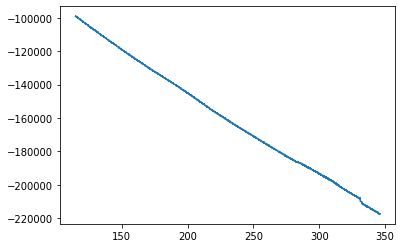

In [6]:
plt.plot(data_blinkGaze_detrended["time_seconds"][15000:45000], data_blinkGaze_detrended["eog0"][15000:45000])

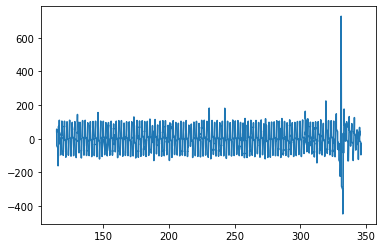

In [9]:
plt.plot(data_blinkGaze_detrended["time_seconds"][15000:45000], signal_filter_butterworth(data_blinkGaze_detrended["eog0"][15000:45000], 250, 0.5, 10))

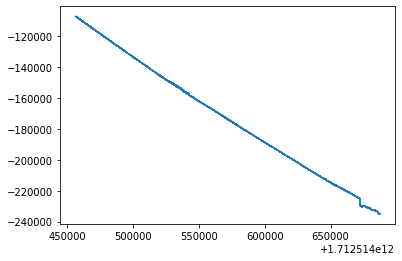

In [11]:
plt.plot(data_blinkGaze_detrended["timestamp"][15000:45000],data_blinkGaze_detrended["eeg1"][15000:45000])

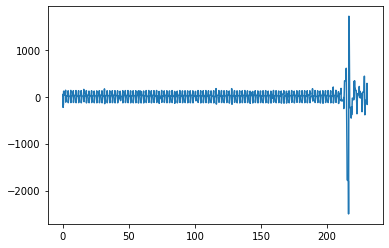

In [12]:
plt.plot(data_blinkGaze_detrended["time_seconds"][0:30000], signal_filter_butterworth(data_blinkGaze_detrended["eeg0"][15000:45000], 250, 0.5, 10))

In [16]:
label_blinkGaze["instruction"].unique()

array([nan, 'lightblink', 'white', 'rest', 'longblink', 'gazeright',
       'gazeleft', 'Rest', '3minBreak'], dtype=object)

# IV. Merge EOG/EEG Data and Study Label

In [18]:
# def create_label(row, specifiedLabel_seconds, time_window): # Calculate nearest index
#     nearest_idx = np.argmin(np.abs(specifiedLabel_seconds - row['time_seconds']))
#     if not (0 <= nearest_idx < len(specifiedLabel_seconds)):
#         return 0  # Invalid nearest index
    
#     if abs(row['time_seconds'] - specifiedLabel_seconds.iloc[nearest_idx]) <= time_window:
#         return 1
#     else:
#         return 0

In [19]:
# # Task 2: Create a copy of data_channels and name it merged_data
# merged_data = data_channels_subset.copy()
# merged_data = merged_data[merged_data["time_seconds"]>=0]
# time_window = 0.5

# study_labels_subset.reset_index(drop=True, inplace=True)
# merged_data.reset_index(drop=True, inplace=True)

# ##################################LABEL: BLINK############################################
# blink = study_labels_subset[study_labels_subset["blink_instruction"]==1]
# blink_timestamps = blink['time_seconds']

# merged_data['blinkLabel'] = merged_data.apply(lambda row: create_label(row, blink_timestamps, time_window), axis=1)

# ##################################LABEL: BLINK############################################
# #blink = study_labels_subset[study_labels_subset["lightblink_instruction"]==1]
# #blink_timestamps = blink['time_seconds']

# #merged_data['lightblinkLabel'] = merged_data.apply(lambda row: create_label(row, blink_timestamps, time_window), axis=1)

# ##################################LABEL: BLINK############################################
# #blink = study_labels_subset[study_labels_subset["longblink_instruction"]==1]
# #blink_timestamps = blink['time_seconds']

# #merged_data['longblinkLabel'] = merged_data.apply(lambda row: create_label(row, blink_timestamps, time_window), axis=1)

# ##################################LABEL: GAZELR ############################################
# gazeLR = study_labels_subset[study_labels_subset["gazeLR_instruction"]==1]
# gazeLR_timestamps = gazeLR['time_seconds']
# merged_data['gazeLRLabel'] = merged_data.apply(lambda row: create_label(row, gazeLR_timestamps, time_window), axis=1)

# ##################################LABEL: GAZELEFT ############################################
# gazeLR = study_labels_subset[study_labels_subset["gazeLeft_instruction"]==1]
# gazeLR_timestamps = gazeLR['time_seconds']
# merged_data['gazeLeftLabel'] = merged_data.apply(lambda row: create_label(row, gazeLR_timestamps, time_window), axis=1)

# ##################################LABEL: GAZELRIGHT ############################################
# gazeLR = study_labels_subset[study_labels_subset["gazeRight_instruction"]==1]
# gazeLR_timestamps = gazeLR['time_seconds']
# merged_data['gazeRightLabel'] = merged_data.apply(lambda row: create_label(row, gazeLR_timestamps, time_window), axis=1)

# ##################################LABEL: REST ############################################
# rest = study_labels_subset[study_labels_subset["rest_instruction"]==1]
# rest_timestamps = rest['time_seconds']
# merged_data['restLabel'] = merged_data.apply(lambda row: create_label(row, rest_timestamps, time_window), axis=1)

In [20]:
# pd.reset_option('display.max_rows')
# print(merged_data.iloc[:80, :])

In [21]:
# merged_data

In [22]:
# prepared_data_channels = merged_data.loc[:, ["timestamp", "eeg0", "eeg1", "eog0", "time_seconds", "blinkLabel","gazeLRLabel", "gazeLeftLabel", "gazeRightLabel", "restLabel"]]

# prepared_data_channels

In [23]:
# study_labels_subset.columns

In [24]:
# prepared_study_labels = study_labels_subset.loc[:,["timestamp", "time_seconds", "instruction", "blink_instruction", "gazeLeft_instruction", "gazeRight_instruction", "gazeLR_instruction","rest_instruction"]]
# prepared_study_labels